# Optics

In this notebook we will explore diffraction effects and  the design of telesopces using ray tracing. 

We will understand how diffractive effects influcence astronomical instruments,  This includes the calculation of point-spread funcitons (also knon as beams at radio frequencies), we will compute an example of a slit spectrometer, and we will examine the funciton of aperature masks for rejecting starlight to image faint comapnions.  We will see how the fourier transform can be used to compute both near field and far-field diffraciton effects.  This computatinal tool will greatly simplify these calculations compared to anaytic computations.  

We will undersatnd the terminology of optics as they relate to the design and funciton of telescopes including magnifciation, plate-scale, field of view, and aberations.  We will use a python raytracing code to study the example of the Hubble space telescope.

## Light as a Wave

It is well known that light behaves as a wave.   I am sure you have derived the vacuume solutions to Maxwell's equsiotns in the form of a family of plane waves with electic field $$\vec E(\vec r, t) = \vec E_0 e^{i (\vec k 
\cdot \vec r \pm \omega t)}$$

Where $\vec k  = k_x \hat x+ k_y \hat x + k_x \hat z$ is the propigation vector which encodes the direction of energy flow of this wave and is related to the wavelenght $\lambda$ by $|\vec k|  = \frac {2 \pi}{\lambda}$; $r =  x \hat x+ y \hat x + z \hat z$ is position in space; $t$ is time; $\omega = {2 \pi} {\nu}$ is the angular frequency which is realted to wavelength and the speed of light $c$ by $c = \lambda \nu = \frac \omega {|k|}$; and $\vec E_0$ which must be ortagonal to $\vec k$, defines the electric field amplitude and polairzaiotion.

This represntation of light as a family of plane waves with different direcitons, polarizaitons, and  wavelengths is useful when considering light passiing through large empty spaces. What we will consider today is the phenomina that arise when light passes through a finite opening.  This opeing could be an aperature of a telescope, part of the detector system, a diffraiton grating, or any number of other compoents in our optical system.

As a prelude to discussing this it is refreshing to water waves. The photo below highlights how plane wave move around an opstical.  You can see clearly that the plane wave hits the break wall, and then diffracts around to create a roughly circular wave pattern in the shaddow.  As a fun reference, [This paper](https://iopscience.iop.org/article/10.1088/0031-9120/47/1/73/pdf) describes using google earth images to think about waves.) We will revisit these effects in the context of light throughout this notebook.

![water waves](http://www.coastalwiki.org/w/images/9/99/WaveDiffraction.jpg)

A direct solution of Maxell's equations is often quite difficult in the case of radiaiton and diffraction.  This there are a set of convenient simplifcaitons that are quite helpful in approximating solutions for diffraciton and radiation.  These approximations can be understood in terms of the distance from the diffracing optical element.  The zones of interest are the Near field which is electromagnetic fields relatively close to the optic where they undergo rapid evolution; and the Far field which is distant from the optic with appriximatly constant behavior when encoded in angular coordinates.  

The confocal distance is defined as: $z_c = \frac {D^2}{\lambda}$ where $D$ is the diamter of the optical element and $\lambda$ is wevelenght.  This quantity providdes an estimate of the distance from the object where the transion from the near to far field occurs.   This tarnsition is gradual and care must be taken when considering the field a lengths that aren't much larger or smaller than $z_c$. A useful discsion of of the near and far field regions can be found [here](https://en.wikipedia.org/wiki/Near_and_far_field).

In what follows we will first discuss Freunhoffer Diffraction and provide example calcuations of the far-field properties of optiacl systems.   Subsequently we will discuss Frenesel Diffraciton and near field effects.


## Fraunhofer diffraction

[Fraunhofer diffraction](https://en.wikipedia.org/wiki/Fraunhofer_diffraction) describes light pripigateion in fhe far field region at a distance $z$ from an optic of diameter $D$ where $z$ is large compared  to the confocal distance.  The [Fraunhofer equation](https://en.wikipedia.org/wiki/Fraunhofer_diffraction_equation) give the eletric field in the far field $U(x,y,z)$ in terms of an integral over the two-dimensional field on the diffracting aperture $A(x',y')$.  
$$U(x,y,z) = \int_{Aperature} A(x',y')e^{i\frac{2 \pi}{\lambda}(\frac x z x' + \frac y z y')} dx' dy'.$$  Here I am addopting the notation from Wikipedia :(.  Note that both $U$ and $A$ are complex functions and in their full glory are vector fields.   In what follows we will consider only the dominat polarizaiton and will apporximate $U$ and $A$ as scalars. This equaiton can be drived by summing the phase of all paths from the source to the field point of 
interest and making various geometrical simplications as discussed [here](https://en.wikipedia.org/wiki/Fraunhofer_diffraction).

In the small angle limit (e.g., where $x << z$ and $y << z$, we can introduce angular coordiantes $\theta_x$ and $\theta_y$ and rewrite this equation as:
$$U(\theta_x,\theta_y) = \int_{Aperature} A(x',y')e^{i\frac{2 \pi}{\lambda}( \theta_x x' + \theta_y y')}dx' dy'.$$
We will work exclusively with this form of the equation since it eliminates the cumborsome and $z$ depandnace in favor of an agular treatment that contains all the inforamtion.  You will notice that this equation is exactly a two dimensional fourier transfomrm.  This to compute the far field diffraciton pattern, all we need to do is to take the fields on the aperture and carry out the FFT to arrive at the diffraction pattern.   We will work a number of numerical examples.

One extremely useful note:  If we have a two dimensional array that represents the aperature fields $A$ whcih has $N$ points on each side at a spacing $\Delta x = \Delta y$, then the grid spacing of the far field is given by $\Delta \theta_x = \Delta \theta_y = \frac \lambda { N \Delta x}. $ Equivelently, the length of a side of our far field grid is $\frac \lambda {\Delta_x}.$




A second useful note is that when it comes to interpreting these results we will often plot the square of the far field.  This is because the received power is proporational to $E^2$ so we can interpret this as the probility that a photon emitted from a partical direction will be detected by our system.


### Example 1: diffraction from a circular aperature

Lets calcuate the diffraciton of a cricular apature

First read in the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Next we will create aperture fields for a circular aperature

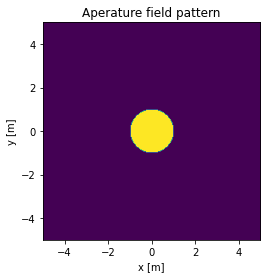

In [2]:
## set up the aperature fields
N = 256  ## number of samples in the aparture plane
L = 10.  ## lenght of the aperture plane in meters-- this must be bigger than field region.
         ## NOTE-- L = N*Delta_x as defined in the text above 
Diam = 2. ## the diameter of our optic
delta_x = L / N

## make coordinate arrays on the aperature palne
y,x = np.meshgrid(np.linspace(-L/2,L/2,N),  ## cartesian coordinates
                  np.linspace(-L/2,L/2,N))
r = np.sqrt(x**2 + y**2)                    ## radial coordainte

## make the aperature fields 
A = np.ones([N,N])
A[np.where(r>Diam/2)] = 0

## plot the aperature fields
plt.imshow(A,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Aperature field pattern")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

Next we use the FFT to compute the far field diffraction pattern.

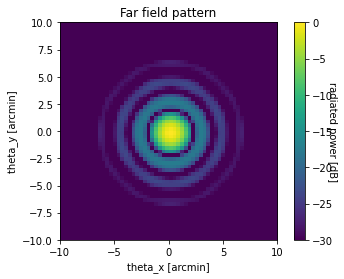

In [3]:
## choose a wavelegth
wavelength = 0.001 ## in meters

## computers rock-- this is the entire calcuation.  Try doing this by hand for a comparsion
U = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A)))

##. THIS WAS THE HARD PART!!!!  the rest is unit conversion and making a nice plot
####################################################



####################################################
## convert from electric field to radiated power or PSF
PSF = np.abs(U)**2
PSF /= np.max(PSF)

## make a logrythmic version of the radiated power so we can better see faint features
PSF +=1e-25 ## avoid infinities by regularizing zeroes
PSF_dB = 10*np.log10(PSF)


## now to make coordinates for these fields
angular_width = wavelength / delta_x  ## this is in radians
angular_width *= 180./np.pi       ## this converts to degrees
angular_width *= 60      ## this converts to arcmin
#angular_width *= 60      ## this converts to arcsec


###########################################
## plot the aperature fields
plot_lim = 10.
plt.imshow(PSF_dB,
           vmin = -30,
           vmax = 0,
           extent=([-angular_width/2, angular_width/2, -angular_width/2, angular_width/2]))

cbar = plt.colorbar()
cbar.set_label("radiated power [dB]", rotation=270)
plt.title("Far field pattern")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("theta_y [arcmin]")
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)

plt.show()



This example (diffracton pattern from a cricular aperture) is called the Airy Pattern or alternatively the Airy Disc.

This square of this field pattern is intrepted as the probability that a photon (in a plane wave state) that hits the telescope will be detected.  If we imagine placing a single pixel at the focal plane of our telescope we could make an image of the sky by pointing the telescope to a grid of angles, recroding the data and plotting an image.  If the sky contained a signle bright source, then we would recover a map of this diffraciton pattern.  In other words our detectors record the convoliton of a sky map with this diffraction pattern.  For this reason we refer to the diffraciton pattern as the Point Spread Funciton or PSF at optical wavelenghts.  At radio and millimere wavelenhts this is refered to as the beam. 

The beam pattern (PSF) is clarly a complex two dimesioanl funciton.  We describe the central region as the main beam or main lobe.  The rings which encircle the main beam are called sidelobes.   While these sidelobes are perfecly symetric, complciated optical systems can create much more comlex sidelobes through diffraciton, scattering, and many other complex effects. 

The widht of the beam can be quantifed with the full width half max (FWHM), which is the diameter at which this beam falls to half its peak value.   It turns out that 0.5 is almost exacly -3dB.  This makes it relatively easy to read off the width of the beam from a plot in dB.  Note that the 30db range spance a factor of 1000 in response.  Instruments that meaure the cosmic microwave background routinly characterize their beams to -60 dB and even lower in the far sidelobes.


### Excercise 

What happend if you double the diameter of the aperture?   Make a prediction, and then put code in the box below to do this caculation.  Did the results vary as expected? Estimate the FWHM of the beams in both cases.  Show the aperature and far fields.  What is the relation between mirror diameter and resoliton? 

 discussion goes here

In [4]:
## your code goes here

### Excercise 

What will happen if you double the wavelength?   Make a prediction, and then put code in the box below to do this caculation.  Did the results vary as expected?  Show the aperature and far fields.  Estimate the FWHM of the beams in both cases.  To make the comparison easy, use the same mirror diameter and grid as you chose in the previous example.  What is the relation between wavelength and resoliton at fixed telecope aperature? 

 discussion goes here

In [5]:
## your code goes here

##  point-spread functions, and the impct on imaging

As disccused above when we use a telecope to produce an image, the output is the convoliton of the sky with the PSF.  Here, followign Rayleigh, we consider the image formed from two closely spaced stars

angular seperation between sources:  2.0626480624709638  arc min
compare this to the FWHM


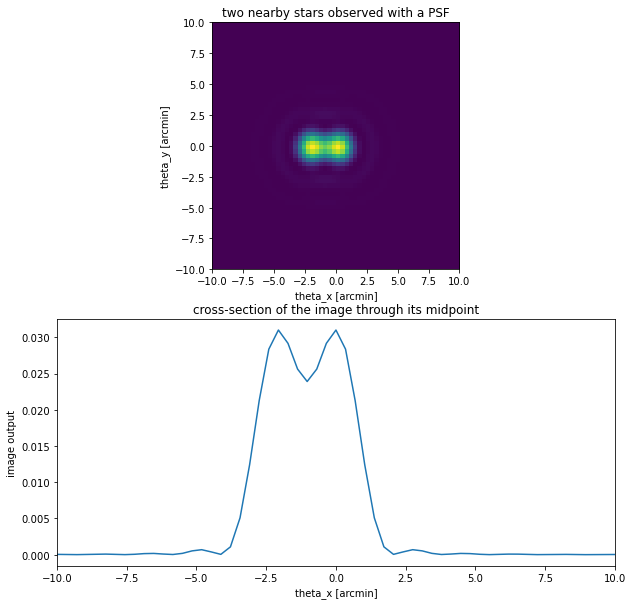

In [6]:
## make a fake sky with two point sources
n_offset = 6
sky = np.zeros(np.shape(PSF))
sky[int(N/2),int(N/2)] = 1.
sky[int(N/2),int(N/2 -n_offset)] = 1.

ang_offset = n_offset * angular_width / N
print("angular seperation between sources: ", ang_offset, " arc min")
print("compare this to the FWHM")



## create an image by convolving the sky with the PSF
## do the calculation using the convolution theorem of fourier analysis
image=  np.fft.fft2(np.fft.fftshift(sky))
image*= np.fft.fft2(np.fft.fftshift(PSF / np.sum(PSF)))   ## this is the PSF in linear scale!
image = np.fft.fftshift(np.fft.ifft2(image))
image = np.real(image)



plt.figure(figsize=(10, 10))


## plot the image
plt.subplot(2, 1, 1) 
plt.imshow(image,
           extent=([-angular_width/2, angular_width/2, -angular_width/2, angular_width/2]))
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)
plt.title("two nearby stars observed with a PSF")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("theta_y [arcmin]")

## plot a cross section of that plot
plt.subplot(2, 1, 2)
theta_x= (np.arange(N)-N/2)/N * angular_width
plt.plot(theta_x,image[int(N/2),:])
plt.xlim(-plot_lim, plot_lim) 
plt.title("cross-section of the image through its midpoint")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("image output")
plt.show()



It is clear (assumig you haven't adjusted the default paramters for the beam width before lookgin at this cell) that the two stars are distingusable using this optical system.  However, if the stars were much closer together the PSF would make it impossible to distingush these two sources.  We call this the resoliton limit.  There are many ways to quantify and discuss this [resoltion limit](https://en.wikipedia.org/wiki/Angular_resolution), but the most famous is the Rayleigh  criteion which says that the resoliton limit of a telescope with aperature diameter $D$ is given by $$\Theta_{min}= \frac {1.22 \lambda} D $$.

The Rayleigh criterion tells you the best resoltion possible with a propery designed and perfectly excecuted telescope.  It is defined such that: two point sources are regarded as just resolved when the principal diffraction maximum (center) of the Airy disk of one image coincides with the first minimum of the Airy disk of the other.  The seperation of the point sources was chosen to be close to this criterian to build intuition about it.

# Beyond the circular aperature

Here we consider several examples beyond the uniformly illuminated circular aperture.  These examples highligth important consideraions in opics relevent to astronomy.

## diffraction spikes 

Most optical telescopes are include blockages in the aperture for the sconday mirror, and support structures refered to as spiders.   Here we model these effects to create a more realistic PSF.  We will compute the example by mofifying the code we set up for the circular aperature.

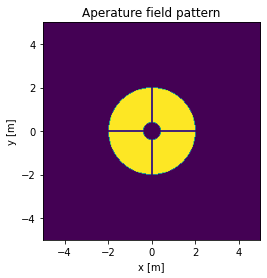

In [7]:
N = 256  ## number of samples in the aparture plane

## paratmers to define the apertrure which is partially blocked by a secondary and a seconday support (spider)
Diam = 4. ## the diameter of our optic
Diam_secondary = Diam / 5
W_spider = Diam/200.
delta_x = L / N

## make coordinate arrays on the aperature palne
y,x = np.meshgrid(np.linspace(-L/2,L/2,N),  ## cartesian coordinates
                  np.linspace(-L/2,L/2,N))
r = np.sqrt(x**2 + y**2)                    ## radial coordainte




## make the aperature fields 
A = np.ones([N,N])
A[np.where(r>Diam/2)] = 0
A[np.where(r<Diam_secondary/2)] = 0  ## block the secondary
A[np.where(np.abs(x)<W_spider)] = 0  ## block the y-spider
A[np.where(np.abs(y)<W_spider)] = 0  ## block the y-spider

## plot the aperature fields
plt.imshow(A,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Aperature field pattern")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

(-20.0, 20.0)

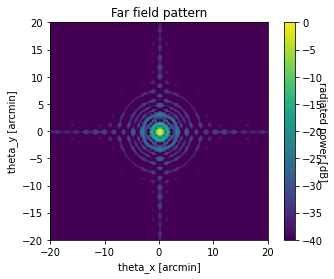

In [8]:
## computers rock-- this is the entire calcuation.  Try doing this by hand for a comparsion
U = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A)))

####################################################
## convert from electric field to radiated power or PSF
PSF = np.abs(U)**2
PSF /= np.max(PSF)

## make a logrythmic version of the radiated power so we can better see faint features
PSF +=1e-25 ## avoid infinities by regularizing zeroes
PSF_dB = 10*np.log10(PSF)

###
## now to make coordinates for these fields
angular_width = wavelength / delta_x  ## this is in radians
angular_width *= 180./np.pi       ## this converts to degrees
angular_width *= 60      ## this converts to arcmin
#angular_width *= 60      ## this converts to arcsec


###########################################
## plot the PSF 
plot_lim = 20.
plt.imshow(PSF_dB,
           vmin = -40,
           vmax = 0,
           extent=([-angular_width/2, angular_width/2, -angular_width/2, angular_width/2]))

cbar = plt.colorbar()
cbar.set_label("radiated power [dB]", rotation=270)
plt.title("Far field pattern")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("theta_y [arcmin]")
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)


See the diffraction spikes!    Later we will convolve this with a simulated sy to get a realistic simulated image.

#### excericises 
1. turn off the horizontal spider and repeate this calculation.  Does the horizontal or verticla diffraciton sprike go away?
1. make the spider blockage wider.  (eg thicker supports).  what happens to the shape of the diffraction spikes?
1. double the diameter of the secondary. what happens to the diffraction pattern

your responses go here

#### Advanced Excercise
Generate a random sky comprised of 1000 point source randomly placed with amplitude drawn from an exponetial disribution.  Convolve this with the realitic PSF we made.  Adjust the PSF to represtnt a 4 m telescope.   Do the brightest sources show diffraction spikes? 

Repeat this for three different wavelenghts.  (Pehraps the sloan g, r, and i bands?)  As an optioanl chalange, create a three color image from these single frequency maps.  The techncial challenge is that you need to do somethign to make the gridding of these images have the same spatial coordinates.  Opetions include setting up different grids, or applying some interpolation scheme.  If you do it right you should see color seperation in the diffraction spikes.

In [9]:
## your code goes here.

## aberations 

Imperfections in the telescope (mirrors, lenses, etc.) lead to variaions in the phase on the aperture palne.  These phase varaitions can be decomposed into [Zernike Polynomials](https://en.wikipedia.org/wiki/Zernike_polynomials). Zernike polynomails are convenient since each mode maps onto named types of aperations that have definate meaning and well studied mitigations in the opticla literature.  We will now generate a random sum of the leading order aberaitons and observe the imapct on the beam.


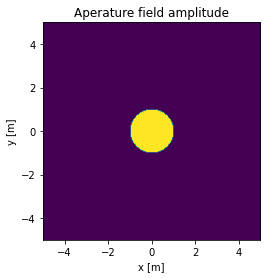

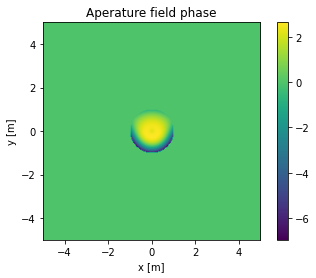

In [84]:
## set up the aperature fields
N = 256  ## number of samples in the aparture plane
L = 10.  ## lenght of the aperture plane in meters-- this must be bigger than field region.
         ## NOTE-- L = N*Delta_x as defined in the text above 
Diam = 2. ## the diameter of our optic
delta_x = L / N

## make coordinate arrays on the aperature palne
y,x = np.meshgrid(np.linspace(-L/2,L/2,N),  ## cartesian coordinates
                  np.linspace(-L/2,L/2,N))
r = np.sqrt(x**2 + y**2)                    ## radial coordainte
phi = np.arctan(y,x)


## make the aperature fields 
A = np.ones([N,N])
A[np.where(r>Diam/2)] = 0

###########################################################################
#####. THE NEW PART: PHASE
rho = r/(Diam/2.)  ## coordinate for computing the zernike polnomails

## we have neglected piston and tild as these just repoint the telescope
Zm2p2 = np.sqrt(6)*rho**2*np.sin(2*phi)  ## oblique astigmatism
Zp0p2 = np.sqrt(3)*(2*rho**2 -1)          ## defocus
Zp2p2 = np.sqrt(6)*(rho**2)*np.sin(2*phi)  ## vertical astigmatism
Zm3p3 = np.sqrt(8)*rho**3*np.sin(3*phi)   ## vertical trefiol
Zm1p3 = np.sqrt(8)*(3*rho**3 - 2*rho)*np.sin(phi) ## vertical coma
Zp1p3 = np.sqrt(8)*(3*rho**3 - 2*rho)*np.cos(phi) ## horizontal coma
Zp3p3 = np.sqrt(8)*rho**3*np.cos(3*phi)   ## oblique trefiol


phase = np.random.randn()*Zm2p2
phase +=np.random.randn()*Zp0p2
phase +=np.random.randn()*Zp2p2
phase +=np.random.randn()*Zm3p3
phase +=np.random.randn()*Zm1p3
phase +=np.random.randn()*Zp1p3
phase +=np.random.randn()*Zp3p3


phase*= A  ## zero out the phase where the field is zero-- purely for plotting purposes
###########################################################################

## plot the aperature fields
plt.imshow(A,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Aperature field amplitude")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

plt.imshow(phase,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Aperature field phase")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
cbar = plt.colorbar()
plt.show()

the peak to peak variation in phase is:  4.794521569623415  radians
expressed as wavelenghts this is :  0.7630718075662793  wavelengths


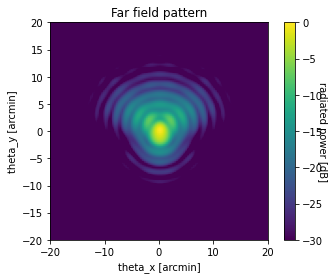

In [85]:
aberation_amplotude = 0.5
print("the peak to peak variation in phase is: ",(np.max(phase) - np.min(phase))*aberation_amplotude, " radians")
print("expressed as wavelenghts this is : ",(np.max(phase) - np.min(phase))*aberation_amplotude/(2*np.pi), " wavelengths")



A_complex = A *np.exp(phase*1j*aberation_amplotude)
## computers rock-- this is the entire calcuation.  Try doing this by hand for a comparsion
U = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A_complex)))


####################################################
## convert from electric field to radiated power or PSF
PSF = np.abs(U)**2
PSF /= np.max(PSF)

## make a logrythmic version of the radiated power so we can better see faint features
PSF +=1e-25 ## avoid infinities by regularizing zeroes
PSF_dB = 10*np.log10(PSF)


## now to make coordinates for these fields
angular_width = wavelength / delta_x  ## this is in radians
angular_width *= 180./np.pi       ## this converts to degrees
angular_width *= 60      ## this converts to arcmin
#angular_width *= 60      ## this converts to arcsec


###########################################
## plot the aperature fields
plot_lim = 20.
plt.imshow(PSF_dB,
           vmin = -30,
           vmax = 0,
           extent=([-angular_width/2, angular_width/2, -angular_width/2, angular_width/2]))

cbar = plt.colorbar()
cbar.set_label("radiated power [dB]", rotation=270)
plt.title("Far field pattern")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("theta_y [arcmin]")
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)

plt.show()




### Exercise: 

generate several realziations of the beam with different aberaitons to get a feel for what can happen when these phase issues are inclulded.  How small (peak to peak) does the phase variation have to be before we reliablly recover something that looks like the Airy Pattern?  Express this as a fraction of the wavelength. 

your answeres go here.

### Ruze scattering

[Ruze scattering](https://en.wikipedia.org/wiki/Ruze%27s_equation) treats the case where there are random errors on a mirror surface (with a coherence scale large compared to the wavelenght) which scatter light out of the main beam.  The Ruze fomrmula says that the fraction of light scatted out of the main beam is given by $$P = P_0 e^{-\left( \frac {4\pi\epsilon} \lambda \right)}$$ where $\epsilon$ is the RMS of the optical surface.  The factor of $4 \pi$ is a combination of converting the error (expressed as a fraciton of wavelength into phase (e.g., $2 \pi$) and a factor of $2$ since light bounces of the mirror surface and accumulates phase on both the halves of this round trip.   

For reference, if $\epsilon = \lambda / 16$ the decreas in received power falls by a factor of 2.  This shows that this is a serious issue for maximizing the signal to noise for measurments of point sources. The net effect of the phase errors is to scatter light to wide angular scales.    We can model this effect by introducing a random distribiton of phase errors normalized by an RMS. 

In the first cell we generate these random phase errors.  In the cell two down we compte the beam after normalizing these to a RMS.

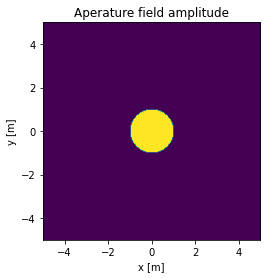

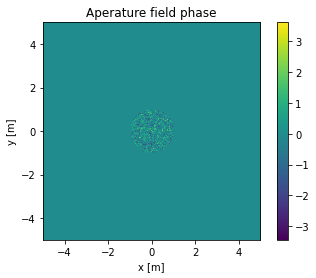

In [73]:
## set up the aperature fields
N = 256  ## number of samples in the aparture plane
L = 10.  ## lenght of the aperture plane in meters-- this must be bigger than field region.
         ## NOTE-- L = N*Delta_x as defined in the text above 
Diam = 2. ## the diameter of our optic
delta_x = L / N

## make coordinate arrays on the aperature palne
x,y = np.meshgrid(np.linspace(-L/2,L/2,N),  ## cartesian coordinates
                  np.linspace(-L/2,L/2,N))
r = np.sqrt(x**2 + y**2)                    ## radial coordainte
phi = np.arctan(y,x)


## make the aperature fields 
A = np.ones([N,N])
A[np.where(r>Diam/2)] = 0

###########################################################################
#####. THE NEW PART: PHASE
phase = np.random.randn(N,N)

phase*= A  ## zero out the phase where the field is zero-- purely for plotting purposes
###########################################################################

## plot the aperature fields
plt.imshow(A,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Aperature field amplitude")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

plt.imshow(phase,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Aperature field phase")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
cbar = plt.colorbar()
plt.show()



epsilon / lambda =  0.06214941254512858
the peak of the PSF is at  2.2570895388353343 M units.


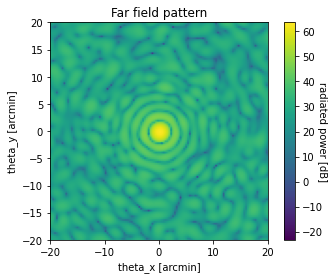

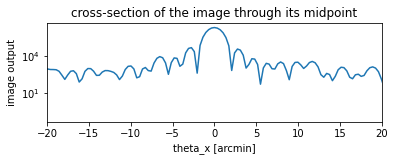

In [74]:
epsilon_over_lambda = 1/16.
print("epsilon / lambda = ",epsilon_over_lambda*np.std(phase[np.where(A !=0)]))


A_complex = A *np.exp(phase*1j*4*np.pi*epsilon_over_lambda )
## computers rock-- this is the entire calcuation.  Try doing this by hand for a comparsion
U = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A_complex)))


####################################################
## convert from electric field to radiated power or PSF
PSF = np.abs(U)**2
##PSF /= np.max(PSF)  ### it is important to turn off the normalziation so we can see the decrease in gain
print("the peak of the PSF is at ",np.max(PSF)/1e6,"M units.")

## make a logrythmic version of the radiated power so we can better see faint features
PSF +=1e-25 ## avoid infinities by regularizing zeroes
PSF_dB = 10*np.log10(PSF)


## now to make coordinates for these fields
angular_width = wavelength / delta_x  ## this is in radians
angular_width *= 180./np.pi       ## this converts to degrees
angular_width *= 60      ## this converts to arcmin
#angular_width *= 60      ## this converts to arcsec


###########################################
## plot the aperature fields
plot_lim = 20.
plt.imshow(PSF_dB,
           #vmin = -30,
           #vmax = 0,
           extent=([-angular_width/2, angular_width/2, -angular_width/2, angular_width/2]))

cbar = plt.colorbar()
cbar.set_label("radiated power [dB]", rotation=270)
plt.title("Far field pattern")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("theta_y [arcmin]")
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)

plt.show()



## plot a cross section of that plot
plt.subplot(2, 1, 2)
theta_x= (np.arange(N)-N/2)/N * angular_width
plt.semilogy(theta_x,PSF[int(N/2),:])
plt.xlim(-plot_lim, plot_lim) 
plt.title("cross-section of the image through its midpoint")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("image output")
plt.show()

### excercises
1. set the RMS error (epsilon_over_lambda) to zero.  Compare this to the deault case of $\epsilon = \lambda / 16$ and show this follows the Ruze formula

1. whave value of $\epsilon / \lambda$ leads to an eficiency of 0.99.

1. Replace the random errors with an RMS error of the Zernike polynomials.   Show that these also follow the ruze formula.   

Notes from your work go here.

In [ ]:
## code for part 3 goes here

### the atmosphere 

At optical wavelenghts, inhomogenaities crated by turbulance, modulate the phase of light as it passes through a telescope resulting in timve varying aberations which degrade the PSF.  This degredation is called Seeing.  We can quantify the impact of seeing by  measuring the diameter of the "seeing disc."  This bluring is one of the reasons good astronomical sites are sought after.   

There are sveral methods for dealing with this effect ranging from speckle interferometry to modern addatptive optics.    We will revisit the natrue of the atmosphere and methods for mitigating its effects later in the course.

## Diffraction Gratings and Spectroscapy
[Diffration gratings](https://en.wikipedia.org/wiki/Diffraction_grating) are comprised of regular features patterned on an optical element.  gratings can be reflective or transmissive.  Gratings are a key tool in spectrometry since they provide a linear relationship between the diffracted angle and wavelength.  This enables a number of ultra precise instruments.   We will study the funciton of these gratings using the tools of Fraunhofer diffraction.  Later in the course we will look at examples of spectroscipic instruments.

## slit diffraction
A conceptulaly simple spectrometer is based on a set of slits.   We will model these using the exact same code that we used above.   For future reference gratings could be periodic reflective surface, surfaces with periodic variations in the index of refraction, and many other possible implemnendations.

### single slit diffraction
We will start by considering diffraciton from a single slit.


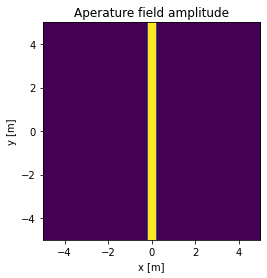

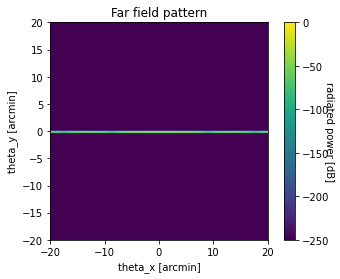

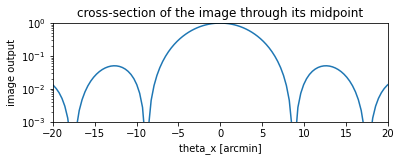

In [115]:
## set up the aperature fields
N = 256  ## number of samples in the aparture plane
L = 10.  ## lenght of the aperture plane in meters-- this must be bigger than field region.

slit_width = 0.4
wavelength = 0.001

## make coordinate arrays on the aperature palne
y,x = np.meshgrid(np.linspace(-L/2,L/2,N),  ## cartesian coordinates
                  np.linspace(-L/2,L/2,N))
r = np.sqrt(x**2 + y**2)                    ## radial coordainte
phi = np.arctan(y,x)


## make the aperature fields 
A = np.zeros([N,N])
A[np.where(np.abs(y)<slit_width/2)] = 1.


## plot the aperature fields
plt.imshow(A,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Aperature field amplitude")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

#################################################################################################


## computers rock-- this is the entire calcuation.  Try doing this by hand for a comparsion
U = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A)))


####################################################
## convert from electric field to radiated power or PSF
PSF = np.abs(U)**2
PSF /= np.max(PSF)  ### it is important to turn off the normalziation so we can see the decrease in gain



## make a logrythmic version of the radiated power so we can better see faint features
PSF +=1e-25 ## avoid infinities by regularizing zeroes
PSF_dB = 10*np.log10(PSF)


## now to make coordinates for these fields
angular_width = wavelength / delta_x  ## this is in radians
angular_width *= 180./np.pi       ## this converts to degrees
angular_width *= 60      ## this converts to arcmin
#angular_width *= 60      ## this converts to arcsec


###########################################
## plot the aperature fields
plot_lim = 20.
plt.imshow(PSF_dB,
           #vmin = -30,
           #vmax = 0,
           extent=([-angular_width/2, angular_width/2, -angular_width/2, angular_width/2]))

cbar = plt.colorbar()
cbar.set_label("radiated power [dB]", rotation=270)
plt.title("Far field pattern")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("theta_y [arcmin]")
plt.xlim(-plot_lim,plot_lim)
plt.ylim(-plot_lim,plot_lim)

plt.show()



## plot a cross section of that plot
plt.subplot(2, 1, 2)
theta_x= (np.arange(N)-N/2)/N * angular_width
plt.semilogy(theta_x,PSF[int(N/2),:])
plt.xlim(-plot_lim, plot_lim) 
plt.ylim(.001,1)
plt.title("cross-section of the image through its midpoint")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("image output")
plt.show()


### excercises

1. explain how the Heisenberg Uncertainty pricniple dictates that the diffraction pattern is elongated perpindicular to the slit.

1. if you double the slit width, what do you expect to happen to the diffraciton pattern?  Check your work and demonstrate you have this right.

1. what happens if you double the wavelegnth.  show this.  How can you use this to create a spectrometer?   Estimate the spectral resolution of this spectrometer which has realatively broad features.

your answeres go here.

### three slit diffraciton

To create a more sensitive gratting we need to create sharper features which are more widely spaced.  Noting that the sharpness of the features scales with the width of the diffracting object, but the spacing increases with narrower features, we will attempt to get the boost the sharpenss of the diffraction features by placing two slits next to eachother.

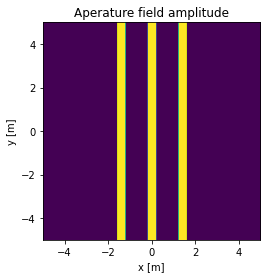

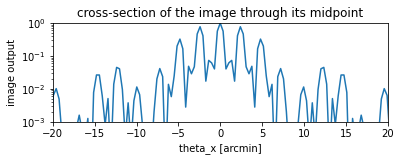

In [134]:
## set up the aperature fields
N = 256  ## number of samples in the aparture plane
L = 10.  ## lenght of the aperture plane in meters-- this must be bigger than field region.

slit_width = 0.4
wavelength = 0.001
slit_spacing = 1.4

## make coordinate arrays on the aperature palne
y,x = np.meshgrid(np.linspace(-L/2,L/2,N),  ## cartesian coordinates
                  np.linspace(-L/2,L/2,N))
r = np.sqrt(x**2 + y**2)                    ## radial coordainte
phi = np.arctan(y,x)


## make the aperature fields 
A = np.zeros([N,N])
A[np.where(np.abs(y)<slit_width/2)] = 1.
A[np.where(np.abs(y+slit_spacing)<slit_width/2)] = 1.
A[np.where(np.abs(y-slit_spacing)<slit_width/2)] = 1.

## plot the aperature fields
plt.imshow(A,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Aperature field amplitude")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

#################################################################################################


## computers rock-- this is the entire calcuation.  Try doing this by hand for a comparsion
U = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A)))


####################################################
## convert from electric field to radiated power or PSF
PSF = np.abs(U)**2
PSF /= np.max(PSF)  ### it is important to turn off the normalziation so we can see the decrease in gain



## make a logrythmic version of the radiated power so we can better see faint features
PSF +=1e-25 ## avoid infinities by regularizing zeroes
PSF_dB = 10*np.log10(PSF)


## now to make coordinates for these fields
angular_width = wavelength / delta_x  ## this is in radians
angular_width *= 180./np.pi       ## this converts to degrees
angular_width *= 60      ## this converts to arcmin
#angular_width *= 60      ## this converts to arcsec


###########################################
## plot the aperature fields



## plot a cross section of that plot
plt.subplot(2, 1, 2)
theta_x= (np.arange(N)-N/2)/N * angular_width
plt.semilogy(theta_x,PSF[int(N/2),:])
plt.xlim(-plot_lim, plot_lim) 
plt.ylim(.001,1)
plt.title("cross-section of the image through its midpoint")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("image output")
plt.show()



### excercises

1. duscuss how this lends itself to a better specrometer

1. does their appear to be an optomal spacing for spectrometry?  try doubling and halving the spacing and see what happens.  Discuss.

1. note how the diffraction pattern of a single slit leads to a modulation of the intensity of the peaks from the three slit interferance.  Would a wider or narrower slit imporve the efficiency of the peaks?

your discussion goes here.

### a periodic grating

Here we consider a periodic gratting for precise spectrometry. 

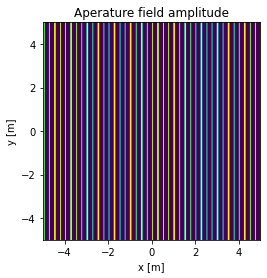

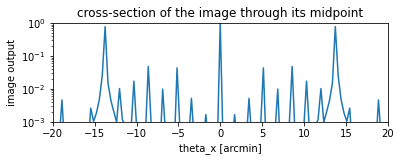

In [133]:
## set up the aperature fields
N = 256  ## number of samples in the aparture plane
L = 10.  ## lenght of the aperture plane in meters-- this must be bigger than field region.

slit_width = 0.1
wavelength = 0.001
slit_spacing = 0.25

## make coordinate arrays on the aperature palne
y,x = np.meshgrid(np.linspace(-L/2,L/2,N),  ## cartesian coordinates
                  np.linspace(-L/2,L/2,N))
r = np.sqrt(x**2 + y**2)                    ## radial coordainte
phi = np.arctan(y,x)


## make the aperature fields 
A = np.zeros([N,N])
A[np.where(np.abs(y % slit_spacing)<slit_width/2)] = 1.

## plot the aperature fields
plt.imshow(A,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Aperature field amplitude")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

#################################################################################################


## computers rock-- this is the entire calcuation.  Try doing this by hand for a comparsion
U = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A)))


####################################################
## convert from electric field to radiated power or PSF
PSF = np.abs(U)**2
PSF /= np.max(PSF)  ### it is important to turn off the normalziation so we can see the decrease in gain



## make a logrythmic version of the radiated power so we can better see faint features
PSF +=1e-25 ## avoid infinities by regularizing zeroes
PSF_dB = 10*np.log10(PSF)


## now to make coordinates for these fields
angular_width = wavelength / delta_x  ## this is in radians
angular_width *= 180./np.pi       ## this converts to degrees
angular_width *= 60      ## this converts to arcmin
#angular_width *= 60      ## this converts to arcsec


###########################################



plot_lim = 20.
## plot a cross section of that plot
plt.subplot(2, 1, 2)
theta_x= (np.arange(N)-N/2)/N * angular_width
plt.semilogy(theta_x,PSF[int(N/2),:])
plt.xlim(-plot_lim, plot_lim) 
plt.ylim(.001,1)
plt.title("cross-section of the image through its midpoint")
plt.xlabel("theta_x [arcmin]")
plt.ylabel("image output")
plt.show()




### excercise

discuss how this could be used to create a precise spectrometer.

## discussion

we have seen that a grating can create a precise spectrometer.  It is clear that there is a tradeoff between the width of the slits (narrower gives wider dispersal) and the spacing between slits (the spacing must create interference within this range).  While we have handled the calculations using numerics to make it easy to focus on the funciton of these devices, this is a place where the analytic treatement is both straightfoward since this is a one dimenional probelm, and powerful since we can understand the fuction and optomaiztion more easily.

One extremely useful analytic result is the diffraction equation: $$d \sin \theta_m = m \lambda.$$ Here $d$ is the spacing between slits, $\theta_m$ is the angular location of a local maxima in the diffraciton, $m$ is an integer that can be both positive and negative, and $\lambda$ is the wavelenght.

This provides a convenient language. We talk about the order of the diffraciton using the ingeger $m$.  Diffraction gratings have multiple orders since they generically have multiple peaks.  The efficiecny of higher orders can be limited if the width of the slits is too large.   This also allows us to understand the frequency dependance of the gratting.  For eample, you can see that the higher orders are more sensitive since a fixed variation in wavelenght leads to a larger angular change as the order increases.  However, one limitation is bandwidht.  One can only operate a grating spectrometer over a wavelength range such that the neighboring peaks do not overlap leading to spectral confusion.  One can show that the bandwith is more limited at higher orders.

A quantity that summarizes the quality of a spectromter is the chromatic resolcing power $$R = \frac {\delta f} f.$$

Here $\delta_f$ is the widht of the diffraciton peak, divivided by its wavelength.  This can be quantified using the Rayleigh criterion and examining the detailed field pattern of the dispersed spectrum.


#### example 1

White light strikes a diffraction grating (760 lines/mm) at normal incidence. What is the longest wavelength that forms a second-order maximum? 
    
We use equation 11. The grating is given in lines/mm, which is $1/d$. The maximum angle possible in 90 degrees. The order $n=2$

$$\frac{\rm{sin}\ 90}{2*760} = 657nm$$

#### example 2
With the same grating as above, you pass light from a sodium lamp through. It is diffracted onto a distant screen.  Two visible lines in the sodium spectrum have wavelengths 498 nm and 569 nm.   
(a)  What is the angular separation Δθ of the first maxima of these spectral lines generated by this diffraction grating? 

Again, use $sin\theta = \frac{n\lambda}{d}$. The order = 1. So for the angle for each line and take the difference.

and solve for  for 498 and 569. Take the difference 
(b) How wide does this grating need to be to allow you to resolve the two lines 589.00 and 589.59 nanometers, which are a well known pair of lines for sodium, in the second order (n = 2)?

Use equation 14. You know $\delta \lambda$ from the question.

####  example 3
SDSS spectral resolution is quoted as between 1850 and 2000 http://classic.sdss.org/dr7/instruments/spectrographs/index.html
Why is there a range? Is this typical for all spectroscopy? What is the typical wavelength resolution of the SDSS (in angstrom)? 
See this paper why it matters:  http://www.bruzual.org/bc03/doc/bc2003.pdf

In [ ]:
------------------------------------------


## Fresnel Diffraction

[Fresnel diffraction](https://en.wikipedia.org/wiki/Fresnel_diffraction) or near field diffraciton allows one to approximate the propigation of light in the near field. The underlying principle of Frensel diffraciotn is Hugynes principle which stats that light propigates from each point as spherical wave.  You may have encountered this principle in an introdcutory physics disccuion of plane waves.  However this same principle explains light in the near field zone.   In effect one takes light on a surface and then for each portion of that surface, propigate light forward as a spherical wave.    With a bit of math and some careful thought one can show that this is mathmatically equivelent to the following convoltion: $$E(x,y,z) = E(x,y,0) * h(x,y,z)$$
where E is the electric field in space, E(x,y,0) is the field on a plane at $z = 0$, and $$h(x,y,z) = \frac {e^{ikz}} {i\lambda z} e^{i \frac k {2z}(x^2 + y^2)}.$$  $h(x,y,z)$ follows from Hyugens principle.  

In what follows we will use this form of Frensel diffraction to compute the near field shaddow of a circular disc.  We will use this to understand the function and design of coronagraphs.  Coronagraphs are devices used to mask out a bright star to reveal fainter objects, which would oherwise be swamped by the background.


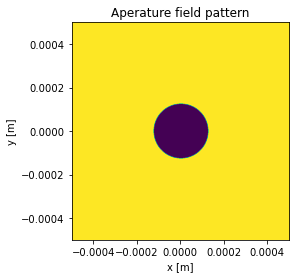

In [147]:
## set up the aperature fields
N = 1024  ## number of samples in the aparture plane
L = 1000e-6  ## lenght of the aperture plane in meters-- this must be bigger than field region.
         ## NOTE-- L = N*Delta_x as defined in the text above 
Diam = 250e-6 ## the diameter of our optic
delta_x = L / N

## make coordinate arrays on the aperature palne
y,x = np.meshgrid(np.linspace(-L/2,L/2,N),  ## cartesian coordinates
                  np.linspace(-L/2,L/2,N))
r = np.sqrt(x**2 + y**2)                    ## radial coordainte

## make the aperature fields 
E_zero = np.zeros([N,N])
E_zero[np.where(r>Diam/2)] = 1

## plot the aperature fields
plt.imshow(E_zero,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Aperature field pattern")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

(1024, 1024)


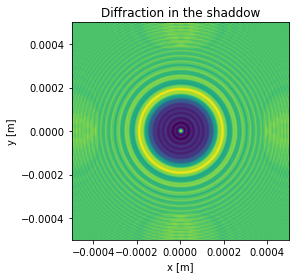

In [193]:
## compute the diffraction in the shaddow of this mask
wavelength = 1000e-9 ## 
z = 5.5e-3

def h(x,y,z,wavelength):
    k = 2*np.pi / wavelength
    output  = np.exp(1j*k*z)
    output /= 1j * wavelength * z
    output *= np.exp(1j *k / (2*z) *(x**2 + y**2))
    return(output)

E_of_z=  np.fft.fft2(np.fft.fftshift(E_zero))
E_of_z*= np.fft.fft2(np.fft.fftshift( h(x,y,z,wavelength)))   ## this is the PSF in linear scale!
E_of_z = np.fft.fftshift(np.fft.ifft2(E_of_z))

print(np.shape(h(x,y,z,wavelength)))


## plot the aperature fields
plt.imshow(np.abs(E_of_z)**2,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Diffraction in the shaddow")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()


## Notes
1. the shadown of an aperture is not dark.  Diffraction fills in behind it with rings inside and also a bright spot at the middle.  This is called the [Argo spot](https://en.wikipedia.org/wiki/Arago_spot)

1. when you pay with paramters beware that the finite grid size and finite resolition will limit this calcuation by causing wrapping (boundary condistions and the conoltion) or lmiting how close you can get to the aperture before the kernal $h(z)$ won't make sense any more.   For this reason I recoemnd $z = 5.5\times10^{-3}$ as the closest distance you consider and to use caution if you move much further away.

### excercise

change the distnace and watch how the diffraciton spot evolves.  

## coronoagraphs 
We use [coronographs](https://en.wikipedia.org/wiki/Coronagraph) to block the light of a central star in order to see the reflected light of planets that otherwise be too difficult to detect above the background on the image.

The simplest coronograph could be made by inserting a circular disc in the optics to block the light from a star.   The calcuation above shows that diffraciotn is our enemy here.  The Argo spot and diffractive rings in the shadow compromise the performance of a simple disc based coronograph.

This motivates more complciated coronagraphs suceh as the star shadaer NASA has proposed to fly in space.  


In [198]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/koUAvH9wkXA" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


lets build a modle of this shadar and see how it works

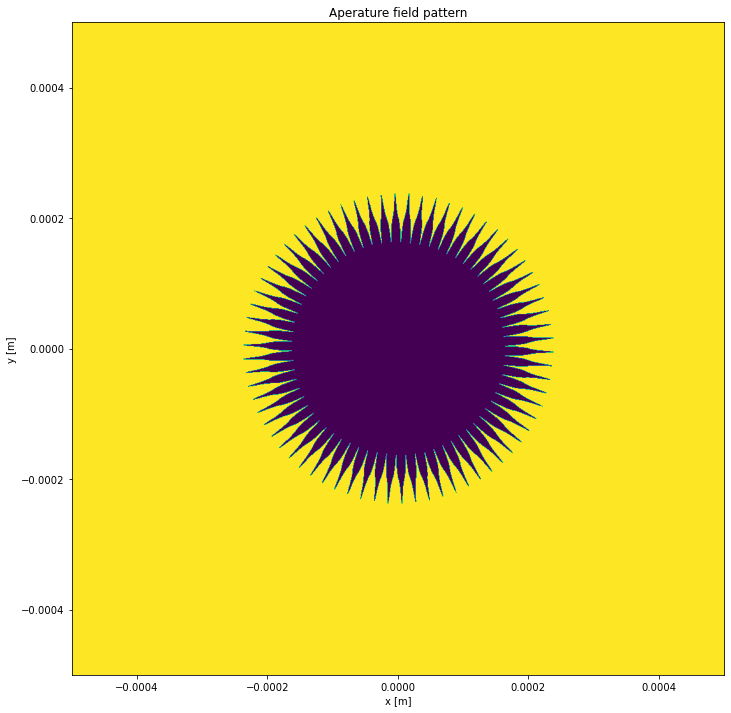

In [233]:
## set up the aperature fields
N = 1024  ## number of samples in the aparture plane
L = 1000e-6  ## lenght of the aperture plane in meters-- this must be bigger than field region.
         ## NOTE-- L = N*Delta_x as defined in the text above 
Diam = 250e-6 ## the diameter of our optic
delta_x = L / N

## make coordinate arrays on the aperature palne
y,x = np.meshgrid(np.linspace(-L/2,L/2,N),  ## cartesian coordinates
                  np.linspace(-L/2,L/2,N))
r = np.sqrt(x**2 + y**2)                    ## radial coordainte
phi = np.arctan2(y,x)


##############

def boundary(th,N_zigs,height_fact):
    r_edge = height_fact + np.sin(N_zigs*th) - .3* np.sin(3*N_zigs*th) + .3**2 * np.sin(5*N_zigs*th) - .3**3 * np.sin(7.*N_zigs*th)
    r_edge = r_edge / np.mean(r_edge)
    return(r_edge)


N_zigs = 70.
height_fact= 15.
def keep_inside(r,theta,N_zigs,height_fact):
    out = np.zeros(np.shape(r))
    stop_edge = boundary(theta,N_zigs,height_fact)
    inside_stop = np.where(r*5e3 < stop_edge)
    out[inside_stop] = 1.
    return(out)

aperature_mask = keep_inside(r,phi,N_zigs,height_fact/2)
E_zero = np.abs(aperature_mask -1)
##################################



## plot the aperature fields
plt.figure(figsize = (12,12))
plt.imshow(E_zero,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Aperature field pattern")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

(1024, 1024)


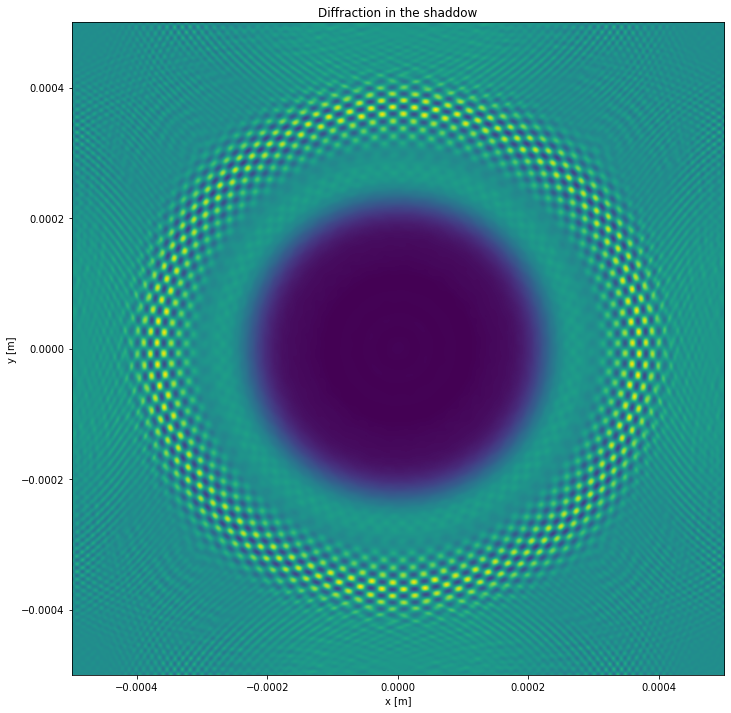

In [236]:

## compute the diffraction in the shaddow of this mask
wavelength = 1000e-9 ## 
z = 5.5e-3

def h(x,y,z,wavelength):
    k = 2*np.pi / wavelength
    output  = np.exp(1j*k*z)
    output /= 1j * wavelength * z
    output *= np.exp(1j *k / (2*z) *(x**2 + y**2))
    return(output)

E_of_z=  np.fft.fft2(np.fft.fftshift(E_zero))
E_of_z*= np.fft.fft2(np.fft.fftshift( h(x,y,z,wavelength)))   ## this is the PSF in linear scale!
E_of_z = np.fft.fftshift(np.fft.ifft2(E_of_z))

print(np.shape(h(x,y,z,wavelength)))


## plot the aperature fields
plt.figure(figsize = (12,12))
plt.imshow(np.abs(E_of_z)**2,extent=([-L/2, L/2, -L/2, L/2]))
plt.title("Diffraction in the shaddow")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

In [ ]:
----------------------------------------------------------------------------------------

### telescopes design


For astronomical telescopes the object distance, S, is large so S = f, and a
quantity of interest is the angular measure, $\theta_s = h/S$, the angle subtended by the
object. 

The inverse of the <i>effective focal length</i> is therefore a scaling factor between
angular measure (on the sky) and linear measure (in the focal plane)

$$\frac{1}{f} = \frac{\theta_s}{|x_T|} \tag{18}$$

where $|x_T|$ is the actual height of the imaged object (i.e., in units of length) and $\theta_S$ is the angular size of that image (on the focal plane)

Equation 18 is known as the <b>plate scale</b> and is given in units of arcsec/mm.

#### the F/number

The f number (f#): f # = f /D where f is the focal length and D is the diameter of the objective (mirror or single lense). 

#### plate scale calculation

From Sutton Chapter 8, we learned that 1/ f is equal to plate scale, or the angular size/physical scale (or $\theta_S/x_T$). This means that f# ≈ 1/$\theta$ .

Consider the Hale 200 inch telescope described [here](http://articles.adsabs.harvard.edu//full/1997JATSo..13....4M/0000009.000.html)

The secondary mirror creates an image just behind the primary with an f # ~20. Since $x_T = \theta_S\ f_T$, we can write:

$$x_T = f_{\#}D_T\theta_S$$

Using the right units and numbers, we can solve for $1/f$ to find a plate scale of 0.387mm/arcsec or 2.6”/mm.

Is the above sensible for 2 pixel sampling of a 1 arcsecond star? Which comes out to 200 microns.

To know, we need to have some idea of the size of a pixel on a CCD. Consider our [MDM CCDS](http://mdm.kpno.noirlab.edu/mdm-ccds.html).  

We see that 20 microns per arcsecond is the norm, which is 10 times the size of what we have for our CCD. This way over sampled (too expensive to build).

So we need to build a new component that shrinks things down, i.e.:

$$f_{\#,C} = (x_d/x_T)f_{\#}$$

where $f_{\#,C}$ is a <i> new camera</i> with a <i> new f-number </i> that shrinks the image to $x_d$. This new camera needs its own f-number to be around 2. Going below 1.5 is hard. Going below 1 is impossible.




